In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
from urllib.parse import urlencode
import ssl
import pandahouse as ph
from scipy import stats
import math

pallet_name = "viridis_r"
my_pallet = sns.color_palette(pallet_name)
sns.set_palette(pallet_name, n_colors=7)

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


def get_download_url(public_key):
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [3]:
# ссылки на используемые документы
links = {
    'groups': 'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
    'groups_add': 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
    'active_studs': 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 
    'checks': 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
}

In [4]:
# Соединение с БД
connection = {
    'database': 'default',
    'host': 'https://clickhouse.lab.karpov.courses',
    'user': 'student', 
    'password': 
}

# Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования **одной гипотезы** 
* **test grp** (B) была предложена новая механика оплаты услуг на сайте
* **control grp** (A) оставалась базовая механика.

Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## Выбор метрик
        
Процесс оплаты происходит в тот момент, когда корзина пользователя уже сформирована. Из чего можно сделать **предположение**, что при проведении тестирования новой механики оплаты мы ожидаем, что это:

* не повлият на ARPPU (только если были внесены какие-то специфичные изменения, предлагающие при офомлении добавить сопутствующий товар)
    
* упростит процесс оплаты, в результате чего увеличится конверсия в покупку.     

Таким образом, при проведении A/B теста будем следить за метриками:
* **СR в покупку** - целевая метрика
* **ARPAU** и **ARPU** - *Guardrail* метрики, т.к. *CR в покупку* влияет на них
* **ARPPU** посомтрим, чтобы не отличалась между группами

## Исследование данных

### groups.csv

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

* **id** - id студента
* **grp** - группа A/B

In [5]:
groups = pd.read_csv(get_download_url(links['groups']), sep=';')
print(*groups.shape)
groups.head(5)

74484 2


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Проверим, что поле id является уникальным. Это гарантирует нам:
* остутствие дублей
* одному студенту присвоена только 1 группа


*Note: кол-во уникальных id должно быть равно 74484*

In [6]:
groups.id.nunique()

74484

#### Распределение групп между студентами

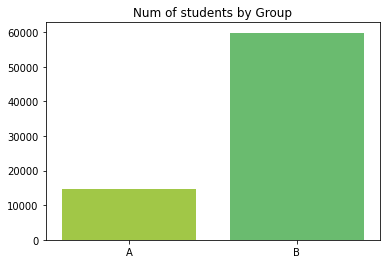

In [7]:
groups = groups.sort_values('grp')
distr_grp = groups.grp.value_counts(sort=False)

sns.barplot(x=distr_grp.index, y=distr_grp.values).set_title("Num of students by Group")
plt.show()

В тестовую группу попало в 4 раза больше студентов

### active_studs.csv

Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* **student_id** - id студента

In [8]:
active_studs = pd.read_csv(get_download_url(links['active_studs']))

# Для удобства переименуем student_id в id
active_studs = active_studs.rename(columns={'student_id': 'id'})

# Для сплитования добавим метку active
active_studs['active'] = True

print(*active_studs.shape)
active_studs.head(5)

8341 2


,id,active
0,581585,True
1,5723133,True
2,3276743,True
3,4238589,True
4,4475369,True


Проверим, что поле id является уникальным. Это гарантирует нам:
* остутствие дублей

*Note: кол-во уникальных id должно быть равно 8341*

In [9]:
active_studs.id.nunique()

8341

Проверим, всем ли активным студентам была присвоена группа.

In [10]:
grp_active = active_studs.merge(groups, how='left', on='id')
print(f'{grp_active.grp.isna().sum()} активным студентам не присвоена группа')

13 активным студентам не присвоена группа


Не будем учитывать этих студентов при расчете основных метрик по группам

#### Распределение групп между студентами, которые проявили активность в дни эксперимента

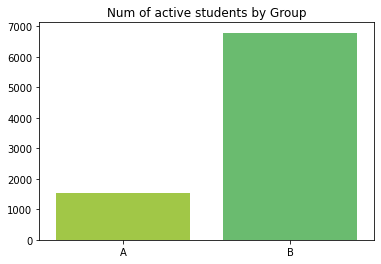

In [11]:
grp_active = grp_active.sort_values('grp')
distr_active_grp = grp_active[~grp_active.grp.isna()].grp.value_counts(sort=False)

sns.barplot(x=distr_active_grp.index, y=distr_active_grp.values).set_title("Num of active students by Group")
plt.show()

In [12]:
# Добавим метку активного студента в таблицу groups, для дальнейшего расчета основных метрик
groups = groups.merge(active_studs, how='left', on='id').fillna(False)

### Проверка конверсии в активного пользователя

Т.к. оплата происходит только после формирования корзины, изменение механики оплаты услуг на сайте, не должно было повлиять на то проявляет ли студент активность на сайте.

In [13]:
# Посмотрим какая доля студентов в группах была активная
groups \
    .groupby('grp', as_index=False) \
    .agg({'active': 'mean'}) \
    .style.format({'active': '{:.2%}'})

,grp,active
0,A,10.46%
1,B,11.36%


Заметим, что конверсия в активного пользователя в группе **B** на 0.9% выше, чем в группе **A**. 

Проверим, являются ли эти отличия статистически значимыми.


Сформулируем гипотезы:

* $\sf{H_{0}}$: Нет взаимосвязи между группой и проявлением активности
* $\sf{H_{1}}$: Факт активности студента и группа взаимосвязаны между собой

#### Таблица сопряженности



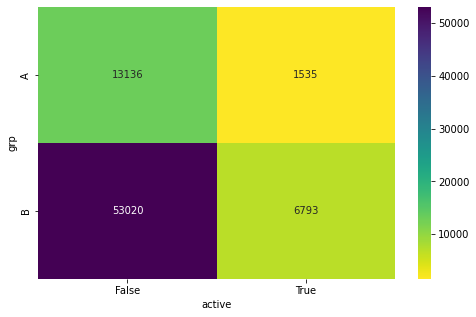

In [14]:
contingency_table_active = groups \
    .pivot_table(values='id', 
                 index='grp', 
                 columns='active', 
                 aggfunc='count')

plt.figure(figsize=(8, 5))
sns.heatmap(contingency_table_active, annot=True, fmt="d", cmap=pallet_name)
plt.show()

Применим тест $\chi ^{2}$

In [15]:
chi2, p, dof, ex = stats.chi2_contingency(contingency_table_active, correction=False)
print(f'''p_value: {p.round(4)}
chi square: {chi2.round(4)}
''')

p_value: 0.0021
chi square: 9.4868



**p-value < 0.05**

У нас достаточно оснований отклонить нулевую гипотезу об остутствии взаимосвязи между группой и проявлением активности студентом.

Конверсия в активного пользователя в группе **B** статистически значимо больше.

Что ставит под сомнение корректность системы сплитования.

### checks.csv

Файл с информацией об оплатах пользователей в дни проведения эксперимента. 
* **student_id** - id студента
* **rev** - оплаты пользователя в дни проведения эксперимента

In [16]:
checks = pd.read_csv(get_download_url(links['checks']), sep=';')

# Для удобства переименуем student_id в id
checks = checks.rename(columns={'student_id': 'id'})

# Для сплитования добавим метку check
checks['purchase'] = True

print(*checks.shape)
checks.head(5)

541 3


,id,rev,purchase
0,1627,990.0,True
1,3185,690.0,True
2,25973,690.0,True
3,26280,690.0,True
4,100300,990.0,True


Проверим, что поле id является уникальным. Это гарантирует нам:
* остутствие дублей
* rev указано суммарно за дни проведения эксперимента, а не отдельными чеками (либо 1 студентом было сделано не более 1 покупки)

*Note: кол-во уникальных id должно быть равно 541*

In [17]:
checks.id.nunique()

541

Проверим, всем ли студентам, совершившим покупку, была присвоена группа.

In [18]:
grp_checks = checks.merge(groups, how='left', on='id')
print(f'{grp_checks.grp.isna().sum()} студенту не присвоена группа')

1 студенту не присвоена группа


Проверим, всем ли студенты, совершившие покупку, были активны

In [19]:
active_checks = checks.merge(active_studs, how='left', on='id')
not_act = active_checks.active.isna().sum()
share_not_act = (not_act * 100 / active_checks.shape[0]).round(2)

print(f'{not_act} купивших студентов не были активны ({share_not_act}% от всех купивших)')

149 купивших студентов не были активны (27.54% от всех купивших)


Сделаем **предположение**, что для студентов, которые не были активными, но все равно купили курс. Изменение механики оплаты не должно повлиять на их конверсию в покупку. Т.к. эти студенты целенаправленно пришли покупать курс и скорее всего доведут этот процесс до конца. 

Исходя из этого предположения, уточним, что целевой метрикой будем учитывать **CR активных студентов в покупку**.

In [20]:
# Добавим метку покупки и сумму в таблицу groups, для дальнейшего расчета основных метрик
groups = groups.merge(checks, how='left', on='id')
groups['purchase'] = groups.purchase.fillna(False)

#### Распределение сумм покупок студентов, по которым присвоена группа

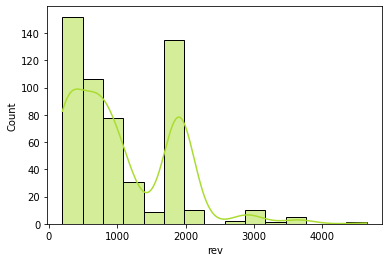

In [21]:
sns.histplot(groups.rev, kde=True, bins=15)
plt.show()

Из графика видно, что студенты в основном покупают курсы на сумму до 2000 руб.

B районе 2000 руб. всплеск покупок. Посмотрим на TOP-5 сумм оплат.

In [22]:
groups.rev.round(2).value_counts().head(5)

1900.0    132
290.0      94
690.0      78
199.0      46
990.0      41
Name: rev, dtype: int64

Видим, что больше всего оплат в 1900 руб. Предположим, что это может быть:
* Курс, который пользуется популярностью
* Акция на один из курсов (В этом случае надо внимательно проверять, чтобы это не влияло на проведение A/B теста)

#### Распределение сумм покупок студентов по группам.

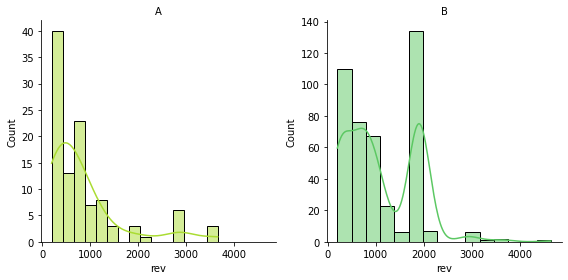

In [23]:
g = sns.FacetGrid(groups, 
                  col="grp", 
                  sharey=False, 
                  height=4, 
                  hue='grp')

g = g.map(sns.histplot, 'rev', kde=True, bins=15)
g.set_titles(col_template="{col_name}")
plt.show()

Из графиков видно, что скачок в 1900 руб сохранился только в группе B.

Посмотрим, какое распределние оплат в 1900 руб между группами

In [24]:
groups.query("rev.round(2) == 1900").grp.value_counts()

B    132
Name: grp, dtype: int64

Видим, что **все** оплаты в 1900 руб приходятся только на тестовую группу. 

### Основные показатели по группам

In [25]:
groups['rev_all'] = groups.apply(lambda x: max(0, x.rev), axis=1)
groups['rev_active'] = groups.apply(lambda x: max(0, x.rev) if x.active else np.nan, axis=1)
groups['purchase_active'] = groups.apply(lambda x: x.rev_active > 0 if x.active else np.nan, axis=1)

In [26]:
rename = {'active': 'CR_to_active',
          'purchase': 'CR_to_purchase',
          'purchase_active': 'CR_active_to_purchase', 
          'rev_all': 'ARPU',
          'rev_active': 'ARPAU', 
          'rev': 'ARPPU'}

In [27]:
main_properties = groups \
    .groupby('grp', as_index=False) \
    .agg({'active': 'mean',
          'purchase': 'mean',
          'purchase_active': 'mean',
          'rev_all': 'mean', 
          'rev_active': 'mean',
          'rev': 'mean'}) \
    .rename(columns=rename)

In [28]:
main_properties \
    .style.format({'CR_to_active': '{:.2%}',
                   'CR_to_purchase': '{:.2%}',
                   'CR_active_to_purchase': '{:.2%}',
                   'ARPU': '{:.2f}',
                   'ARPAU': '{:.2f}',
                   'ARPPU': '{:.2f}'})

,grp,CR_to_active,CR_to_purchase,CR_active_to_purchase,ARPU,ARPAU,ARPPU
0,A,10.46%,0.73%,5.08%,6.28,47.44,860.71
1,B,11.36%,0.72%,4.61%,8.01,57.86,1107.00


В тестовой выборке целевая метрика (**CR в покупку**) снизилась.

Изменение механики оплаты услуг на сайте, не должно было повлиять на **ARPPU**. При этом видим, что в тестовой группе **ARPPU** увеличился.

Посмотрим на метрику **ARPPU** без оплат в 1900 руб.

In [29]:
groups \
    .query('~rev.isna() and rev.round() != 1900') \
    .groupby('grp', as_index=False) \
    .agg({'rev': 'mean'}) \
    .rename(columns={'rev': 'ARPPU_without_1900'}) \
    .style.format({'ARPPU_without_1900': '{:.2f}'})

,grp,ARPPU_without_1900
0,A,860.71
1,B,759.24


На увеличение **ARPPU** повлияли покупки в 1900 руб. Необходимо установить причину появления этих покупок. 

### Проверка ARPPU

Проверим является ли изменение **ARPPU** статистически значимым.

Сформулируем гипотезы:

* $\sf{H_{0}}$: никакого различия между средними значениями нет
* $\sf{H_{1}}$: средние не равны

In [30]:
rev_a = groups.query("grp == 'A' & ~rev.isna()").rev
rev_b = groups.query("grp == 'B' & ~rev.isna()").rev

#### Выбор статистического метода

**1. t-test**. Для проведения t-теста необходимо выполнение следующих условий:

* гомогенность дисперсий
* распределение среднего rev должнго быть нормально

In [31]:
# Посмотрим на гомогеность дисперсий
stats.levene(rev_a, rev_b)

LeveneResult(statistic=4.099799827819432, pvalue=0.043381693677143875)

p-value < 0.05. У наc достаточно оснований отклонить нулевую гипотезу о равенстве дисперсий.

Можно было бы использовать t-тест Уэлча, учитывающий неравенство дисперсий. Но давайте посмотрим на второе необходимое условие.

Распределение среднего rev гарантировано будет нормальным при нормальности распределения.

Посмотрим на qqplot

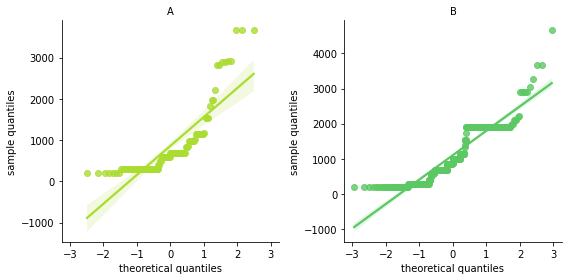

In [32]:
def quantile_plot(x, **kwargs):
    quantiles, xr = stats.probplot(x, fit=False)
    sns.regplot(x=quantiles, y=xr, **kwargs)
    plt.ylabel('sample quantiles')


g = sns.FacetGrid(groups.query('~rev.isna()'), 
                  col="grp", 
                  sharey=False, 
                  height=4, 
                  hue='grp')

g = g.map(quantile_plot, 'rev')
g.set_titles(col_template='{col_name}')
g.set_axis_labels('theoretical quantiles')
plt.show()

Видно, что рапределение отличается от нормального, но это еще не повод отказаться от t-теста.

Т.к. у нас достаточно большой объем данных, все еще можем вопользоваться t-тестом, если в нем нет заметных выбросов.

Проверим есть ли выбросы

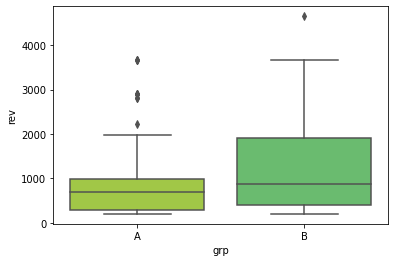

In [33]:
sns.boxplot(x="grp", y="rev", data=groups)
plt.show()

В обеих группах присутствуют потенциальные выбросы.

Т.о. ни одно из условий для выполнения t-теста не выполняется. 

В нашем случае не так много данных, чтобы с уверенностью применять t-тест. Лучше было бы применить непараметрический тест или бутстрап.

**2. U-критерий Манна-Уитни**. 

Этот критерий менее чувствителен к отклонениям от нормальности и наличию выбросов. 

Стоит обратить внимание, что данный критерий переводит данные в ранг, что накладывает ограничение, что в данных не должно быть большое количество совпадающих значений. 

А мы как раз проверяем аномальное количество одлинаковых платежей в 1900 руб.

**Таким образом с учетом:**
* отклонения от нормальности данных
* объема данных
* наличия выбросов
* наличия большого количества совпадающих значений

В нашем случае было бы безопаснее воспользоваться **bootstrap**

In [34]:
boot_len = groups.groupby('grp').agg({'purchase': 'sum'}).purchase.max()
a = groups.query("grp == 'A' & ~rev.isna()").rev
b = groups.query("grp == 'B' & ~rev.isna()").rev

boot_data = []
for _ in range(10000):
    mean_a = np.mean(a.sample(boot_len, replace=True).values)
    mean_b = np.mean(b.sample(boot_len, replace=True).values)
    boot_data.append(mean_b - mean_a)
    
pd_boot_data = pd.DataFrame(boot_data)
quants = pd_boot_data.quantile([0.05 / 2, 1 - 0.05 / 2])

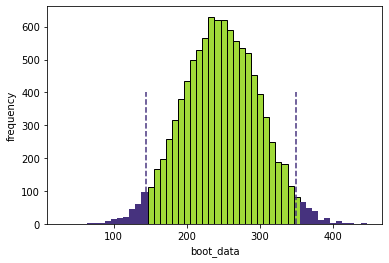

In [35]:
_, _, bars = plt.hist(pd_boot_data[0], bins=50)
for bar in bars:
    if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
        bar.set_facecolor(my_pallet[-1])
    else: 
        bar.set_facecolor(my_pallet[0])
        bar.set_edgecolor('black')
    
plt.vlines(quants, ymin=0, ymax=400, linestyle='--', color=my_pallet[-1])
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.show()

#### Рассчитаем p-value

In [36]:
p_1 = stats.norm.cdf(0, np.mean(boot_data), np.std(boot_data))
p_2 = stats.norm.cdf(0, -np.mean(boot_data), np.std(boot_data))
p_value = min(p_1, p_2) * 2
p_value

2.6120207570736253e-06

**p-value < 0.05.** 

У нас достаточно оснований отклонить нулевую гипотезу о равенстве средних.

ARPPU в тестовой и контрольной группе статистически значимо отличаются.

Необходимо выявить природу возникновения покупок в 1900 руб.

* Была ли проведена акция на один из курсов? Если да, то это ставит под сомнение проведение A/B теста.
* Были ли эти покупки связаны с новой механникой оплаты? Если да, то целевой метрикой надо учитывать ARPPU, который в свою очередь статистически значимо увеличился.

*Note: в самом начале было сделано предположение, что ARPPU мог увеличиться при специфичных изменениях, предлагающих при офомлении добавить сопутствующий товар. Стоит отметить, что наше увеличение ARPPU не похоже на этот случай, т.к. увеличение вызвано покупками в 1900 руб. А добавление сопутствующих товаров, предпологает увеличение суммы уже сформированной корзины.*

*Note: Если это была проведена акция через рассылку, то это объяснило бы статистичечки значимое увеличение конверсии в активного пользователя в группе B.*

## Проверка изменений целевой метрики

Проверим является ли изменение CR в покупку статистически значимым.

Сформулируем гипотезы:

* $\sf{H_{0}}$: Нет взаимосвязи между группой (какая механника оплаты у студента) и фактом совершения покупки
* $\sf{H_{1}}$: Факт совершения покупки и группа взаимосвязаны между собой

### Таблица сопряженности

Будем рассматривать CR активного пользователя в покупку

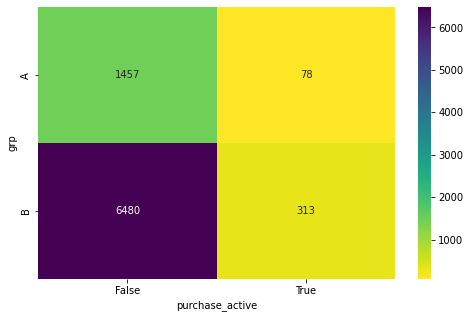

In [37]:
contingency_table = groups \
    .query('active') \
    .pivot_table(values='id', 
                 index='grp', 
                 columns='purchase_active', 
                 aggfunc='count')

plt.figure(figsize=(8, 5))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap=pallet_name)
plt.show()

Все ее значения больше 10. Применим тест $\chi ^{2}$

In [38]:
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction=False)
print(f'''p_value: {p.round(4)}
chi square: {chi2.round(4)}
''')

p_value: 0.4281
chi square: 0.628



**p-value > 0.05** 

У нас не достаточно оснований отклонить нулевую гипотезу. 

CR активного пользователя в покупку статистически значимо не изменился.

### Итог

* Целевой метрикой проведения A/B тестирования был выбран CR активного пользователя в покупку. CR статистически значимо не изменился.
* ARPPU статистически значимо увеличился. Что ставит под сомнение проведение A/B теста. Необходимо уточнить природу возникновения покупок в 1900 руб. И связано ли их появление с изменением страницы оплаты.
* CR в активного пользователя статистически значимо увеличился. Что могло быть вызвано акцией из предыдущего пункта (если акция была рассылкой), либо сломанной сплит-системой. Так же необходимо дополнительно выяснять в чем причина.

# Задание 2. SQL

## 2.1 Очень усердные ученики.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз **за текущий месяц правильно решил 20 горошин**.

Необходимо написать **оптимальный запроc**, который даст информацию о количестве очень усердных студентов.



Сейчас с базе у нас находятся данные только за 2 дня одного месяца.

Т.к. данные будут скорее всего дополняться новыми днями, будем считать **текущим месяцем** последний месяц за который есть данные.

In [39]:
q_diligent_st = '''
WITH(SELECT toStartOfMonth(MAX(timest)) FROM default.peas) AS current_month

SELECT 
    COUNT(*) AS num_diligent_students
FROM
(
    SELECT st_id
    FROM default.peas
    WHERE toStartOfMonth(timest) = current_month
    GROUP BY st_id
    HAVING SUM(correct) >= 20 
)
'''

In [40]:
diligent_st = ph.read_clickhouse(query=q_diligent_st, connection=connection)
diligent_st

,num_diligent_students
0,136


## 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

**ARPU** считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

**Активным по математике** считается пользователь, за все время решивший 2 или больше задач правильно по математике.

### Имеющаяся информация

#### peas

* **st_id** - ID ученика
* **timest** - Время решения карточки
* **correct** - Правильно ли решена горошина?
* **subject** - Дисциплина, в которой находится горошина


#### studs

* **st_id** - ID ученика
* **test_grp** - Метка ученика в данном эксперименте


#### final_project_check
* **st_id** - ID ученика
* **sale_time** - Время покупки
* **money** - Цена, по которой приобрели данный курс
* **subject** - Дисциплина, на которую приобрели полный доступ

### Что делаем

Выберем отдельно:
* **active_st** - из **peas** выделим активных студентов (по всем предметам/по математике)
* **buying_st** - из **final_project_check** выделим студентов, которые совершили покупку (по всем предметам/по математике)

Добавим информацию об активных студентах и студентах купивших курсы к талице **studs** и посчитаем необходимые метрики

In [41]:
q_grp_info = '''
WITH
    active_st AS 
    (
        SELECT 
            st_id,
            SUM(correct) > 10 AS active,
            SUM(correct * (subject = 'Math')) >= 2 AS math_active
        FROM peas
        GROUP BY st_id
        HAVING active OR math_active
    ),
    buying_st AS
    (
        SELECT 
            st_id,
            SUM(money) AS rev,
            SUM(money * (subject = 'Math')) AS math_rev
        FROM final_project_check
        GROUP BY st_id
    ),
    SUM(rev) / COUNT(*) AS ARPU,
    SUM(rev * active) / SUM(active) AS ARPAU,
    SUM(rev > 0)/ COUNT(*) AS CR,
    SUM((rev > 0) * active) / SUM(active) AS CR_active,
    SUM((math_rev > 0) * math_active) / SUM(math_active) AS CR_math_active

SELECT 
    test_grp,
    ARPU,
    ARPAU,
    CR,
    CR_active,
    CR_math_active
FROM studs AS a
LEFT JOIN active_st  AS b ON a.st_id = b.st_id
LEFT JOIN buying_st AS c ON a.st_id = c.st_id
GROUP BY test_grp
'''

In [42]:
grp_inf = ph.read_clickhouse(query=q_grp_info, connection=connection)
grp_inf.style.format({'ARPU': "{:.2f}",
                      'ARPAU': '{:.2f}',
                      'CR': '{:.2%}',
                      'CR_active': '{:.2%}',
                      'CR_math_active': '{:.2%}'})

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math_active
0,control,4540.98,10393.70,4.92%,11.02%,6.12%
1,pilot,11508.47,29739.58,10.85%,26.04%,9.52%


# Задание 3. Python

* Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
* Реализуйте функцию, которая будет строить графики по получаемым метрикам.

**groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [45]:
def add_data(file, group_prev):
    """
        Args:
            file(str) - ссылка на csv файл со структурой: [id студента, группа A/B]
            group_prev(DataFrame) - изначальные данные, которые необходимо дополнить.
                id(int) - id студента
                grp(str) - группа студента
                active(bool) - бфл ли студент активным в дни проведения экперимента
                rev(float) - сумма покупок в дни экперимента
                rev_all(float) - сумма покупок в дни экперимента по всем студентам
                purchase(bool) - факт совершения покупки в дни экперимента
                rev_active(float) - сумма покупок активных студентов в дни экперимента
                purchase_active(bool) - факт совершения покупки активным студентом в дни экперимента
        Returns:
            DataFrame - обновленные основные метрики по группам
    """
    def interval(x):
        std = x.std()
        return 1.96 * std / np.sqrt(x.count())
    
    
    group_add = pd.read_csv(file, names=['id', 'grp'], header=0)
    
    group_add = group_add.merge(active_studs, how='left', on='id').fillna(False)
    group_add = group_add.merge(checks, how='left', on='id')
    group_add['purchase'] = group_add.purchase.fillna(False)
    
    group_add['rev_all'] = group_add.apply(lambda x: max(0, x.rev), axis=1)
    group_add['rev_active'] = group_add.apply(lambda x: max(0, x.rev) if x.active else np.nan, axis=1)
    group_add['purchase_active'] = group_add.apply(lambda x: x.rev_active > 0 if x.active else np.nan, axis=1)
    
    group_new = pd.concat([group_prev, group_add], ignore_index=True)
    
    main_properties = group_new \
        .groupby('grp', as_index=False) \
        .agg({'active': 'mean',
              'purchase': 'mean',
              'purchase_active': 'mean',
              'rev_all': 'mean', 
              'rev_active': 'mean',
              'rev': 'mean'}) \
        .rename(columns=rename)

    intervals = group_new \
        .groupby('grp', as_index=False) \
        .agg({'active': interval,
              'purchase': interval,
              'purchase_active': interval,
              'rev_all': interval, 
              'rev_active': interval,
              'rev': interval}) \
        .rename(columns=rename)

    return main_properties, intervals

In [47]:
main_properties, intervals = add_data(get_download_url(links['groups_add']), groups)

In [48]:
main_properties.style.format({'CR_to_active': '{:.2%}',
                              'CR_to_purchase': '{:.2%}',
                              'CR_active_to_purchase': '{:.2%}', 
                              'ARPU': '{:.2f}',
                              'ARPAU': '{:.2f}',
                              'ARPPU': '{:.2f}'})

,grp,CR_to_active,CR_to_purchase,CR_active_to_purchase,ARPU,ARPAU,ARPPU
0,A,10.47%,0.73%,5.07%,6.27,47.35,860.71
1,B,11.36%,0.72%,4.62%,8.04,58.06,1108.82


In [51]:
def build_errorbar(metrics, interval):   
    def plot(x, y, yerr):
        plt.errorbar(x=x, y=y, yerr=yerr, fmt='o')

        
    plt.figure(figsize=(18, 10))

    fields = metrics.columns
    for i in range(1, 7):
        plt.subplot(230 + i)
        y = metrics[fields[i]] * (100 if fields[i][:2] == 'CR' else  1)
        yerr = interval[fields[i]] * (100 if fields[i][:2] == 'CR' else  1)
        plot(metrics.grp,  y, yerr=yerr)
        plt.ylabel(fields[i])
        plt.xlabel('grp')

    plt.show()

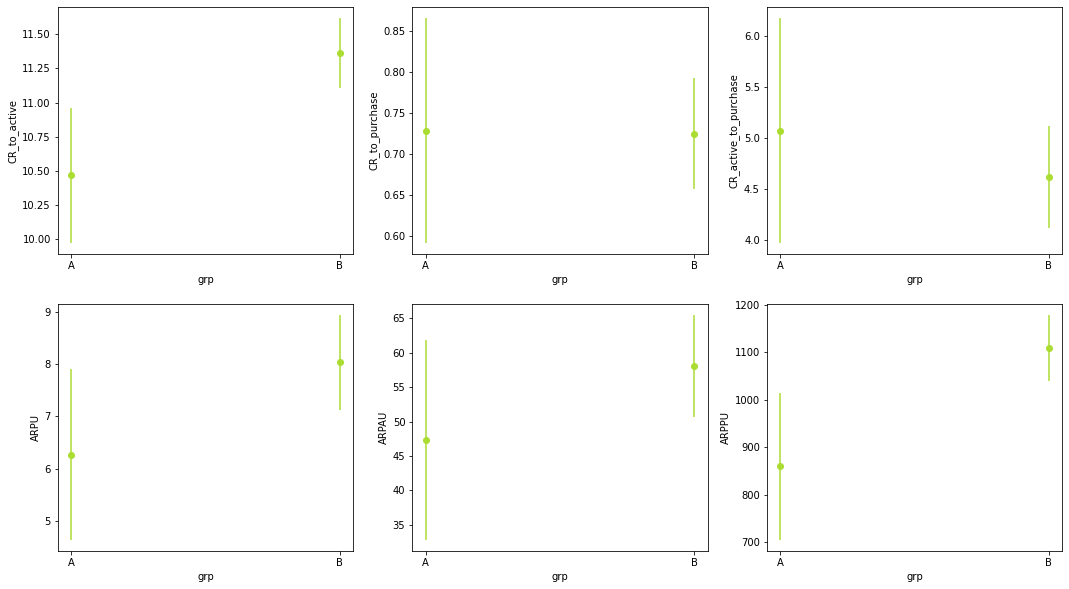

In [52]:
build_errorbar(main_properties, intervals)